In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import PredictImage as prim
import os

In [2]:
cur_cam_index = 0
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

#D = np.array([0.05003216, -0.04567757, 0.06960187, -0.03096402], dtype=np.float64)
D =np.array([  0.08330459003495257, 0.008459725805467274,  0.000681253494528032, 0.0001603712146519313])

image_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c1_img20250512-12_06_55CEST.jpg"
overlay_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c1_img20250512-11_57_42CEST.jpg"


delta_pitch_deg=15.0
delta_yaw_deg=-1.0 
delta_roll_deg=1.0 
delta_r=0.001
#delta_pitch_deg=0.0
#delta_yaw_deg=0.0 
#delta_roll_deg=0.0 
#delta_r=0.0


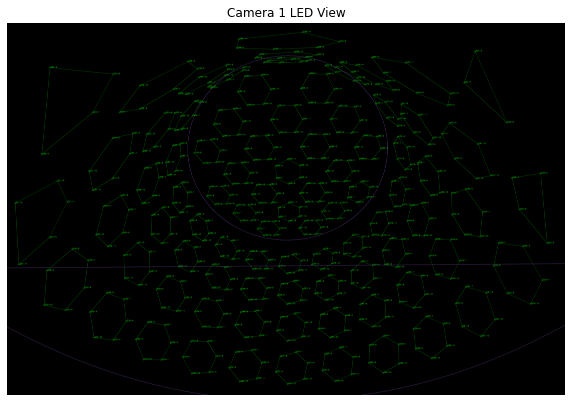

Saved image to camera1_f3253_p15_y-1_r1_dr0.png


In [3]:
excluded_pmts = { 22, 23, 24, 26, 27, 30, 32, 35, 39, 45, 54, 55, 56, 57, 63, 70, 71, 72, 74, 77, 79, 85, 91, 96, 99, 102}


prim.simulate_fisheye_view("wcte_geometry_file.json", camera_index=cur_cam_index, K=K, D=D, delta_pitch_deg=delta_pitch_deg, delta_yaw_deg=delta_yaw_deg, delta_roll_deg=delta_roll_deg, delta_r=delta_r, excluded_pmts={})

In [4]:

blobs = prim.run_blob_detector( cur_cam_index, image_filename_current )
print('number of blobs before filter:',len(blobs))
blobs_filtered = prim.filter_blobs_by_distance(blobs, 50)
print('number of blobs:',len(blobs_filtered))

number of blobs before filter: 217
number of blobs: 217


In [5]:
prim.draw_image_with_blobs_save( cur_cam_index, image_filename_current, blobs_filtered, 'c'+str(cur_cam_index+1)+'_with_blob_annotation.jpg' )

Annotated image saved to: c1_with_blob_annotation.jpg


In [6]:
# Initial guess: [pitch, yaw, roll, r, k1, k2, k3, k4]
initial_guess = [delta_pitch_deg, delta_yaw_deg, delta_roll_deg, delta_r, 
                 D[0], D[1], D[2], D[3] ]

control_points = {
    '052-9': (1646, 3185),
    '043-10': (7530, 4365),
    '086-8': (4035, 2202)
}

matches, fitpars = prim.match_blobs(
                            blobs_filtered, "wcte_geometry_file.json", 
                            cur_cam_index, K, D, initial_guess=initial_guess, 
                            excluded_pmts=excluded_pmts,
                            bounds = [
                                        (-20, 20),   # delta_pitch_deg
                                        (-10, 10),   # delta_yaw_deg
                                        (-10, 10),   # delta_roll_deg
                                        (-0.01, 0.01), # delta_r in meters
                                        (-0.082, 0.086), # k1 [ 0.05003216 -0.04567757  0.06960187 -0.03096402]
                                        (-0.007, 0.009), # k2
                                        (-0.0005, 0.0008), # k3
                                        (-0.0001, 0.0002)   ],

                            control_points=control_points,  
                            use_lm=True )
                                   

In [7]:
fitpars

{'delta_pitch_deg': 15.799231427511403,
 'delta_yaw_deg': -0.7928297638245367,
 'delta_roll_deg': 1.4463795271999862,
 'delta_r': 0.0656921360571453,
 'D_fit': array([-0.04880759,  0.21369394, -0.16525285,  0.04471981]),
 'chi2': 8080273.5759356,
 'success': True}

In [8]:
len(matches)

208

In [9]:
matches

[('021-8', 840.1047, 2739.228),
 ('021-9', 140.21027, 3105.5361),
 ('025-6', 9087.189, 2533.013),
 ('025-7', 8579.351, 2619.9338),
 ('028-6', 7397.2197, 5128.3164),
 ('028-11', 7454.0806, 5473.745),
 ('029-6', 6648.769, 5491.648),
 ('029-7', 6410.878, 5369.649),
 ('029-11', 6649.392, 5789.13),
 ('031-6', 5119.2144, 5814.5435),
 ('031-7', 4917.5083, 5637.4385),
 ('031-8', 4656.286, 5710.478),
 ('031-9', 4582.9824, 5965.684),
 ('031-11', 5060.0483, 6077.9688),
 ('033-6', 3575.0737, 5694.329),
 ('033-7', 3423.0898, 5451.111),
 ('033-8', 3146.9775, 5443.8896),
 ('033-9', 3006.944, 5704.875),
 ('033-10', 3171.8208, 5969.652),
 ('033-11', 3461.3438, 5953.8037),
 ('034-8', 2414.565, 5136.542),
 ('034-9', 2231.0444, 5399.25),
 ('034-10', 2358.3816, 5708.974),
 ('036-8', 1119.1195, 3902.9834),
 ('036-9', 736.85876, 4242.644),
 ('037-8', 2133.816, 1931.9012),
 ('037-9', 1772.7566, 2008.3734),
 ('037-10', 1382.7518, 2572.3625),
 ('038-7', 2794.2854, 965.54224),
 ('038-8', 3234.6875, 795.7982),
 (

In [10]:
img = prim.visualize_all_leds_and_matches( 
    image_filename_current,
    blobs,
    matches,
    fitpars,
    "wcte_geometry_file.json",
    cur_cam_index,
    K,
    fitpars['D_fit'],
    output_filename='c'+str(cur_cam_index+1)+"_blob_match_overlay.png",
    excluded_pmts=excluded_pmts,
    control_points=control_points,    
    overlay_image_name=overlay_filename_current,
    alpha=0.2
)


{'delta_pitch_deg': 15.799231427511403, 'delta_yaw_deg': -0.7928297638245367, 'delta_roll_deg': 1.4463795271999862, 'delta_r': 0.0656921360571453, 'D_fit': array([-0.04880759,  0.21369394, -0.16525285,  0.04471981]), 'chi2': 8080273.5759356, 'success': True}
Overlay image saved to: c1_blob_match_overlay.png


In [11]:
output_filename = os.path.splitext( os.path.basename(image_filename_current) )[0] + ".json"

prim.save_matching_results_to_json(
    output_filename=output_filename,
    image_filename=image_filename_current,
    fitpars=fitpars, 
    matches=matches, 
    blobs=blobs, 
    geo_file="wcte_geometry_file.json", 
    camera_index=cur_cam_index, 
    K=K, 
    D=fitpars['D_fit'], 
    excluded_pmts=excluded_pmts)

excluded_pmts= {70, 71, 72, 74, 77, 79, 85, 22, 23, 24, 26, 27, 91, 30, 32, 96, 35, 99, 102, 39, 45, 54, 55, 56, 57, 63}
geo_file= wcte_geometry_file.json
Sample matches labels: [('021-8', 840.1047, 2739.228), ('021-9', 140.21027, 3105.5361), ('025-6', 9087.189, 2533.013), ('025-7', 8579.351, 2619.9338), ('028-6', 7397.2197, 5128.3164), ('028-11', 7454.0806, 5473.745), ('029-6', 6648.769, 5491.648), ('029-7', 6410.878, 5369.649), ('029-11', 6649.392, 5789.13), ('031-6', 5119.2144, 5814.5435)]
Sample label_to_sim keys: ['021-6', '021-7', '021-8', '021-9', '021-11', '025-6', '025-7', '025-8', '025-9', '028-6']
Saved results to c1_img20250512-12_06_55CEST.json


In [12]:
matches

[('021-8', 840.1047, 2739.228),
 ('021-9', 140.21027, 3105.5361),
 ('025-6', 9087.189, 2533.013),
 ('025-7', 8579.351, 2619.9338),
 ('028-6', 7397.2197, 5128.3164),
 ('028-11', 7454.0806, 5473.745),
 ('029-6', 6648.769, 5491.648),
 ('029-7', 6410.878, 5369.649),
 ('029-11', 6649.392, 5789.13),
 ('031-6', 5119.2144, 5814.5435),
 ('031-7', 4917.5083, 5637.4385),
 ('031-8', 4656.286, 5710.478),
 ('031-9', 4582.9824, 5965.684),
 ('031-11', 5060.0483, 6077.9688),
 ('033-6', 3575.0737, 5694.329),
 ('033-7', 3423.0898, 5451.111),
 ('033-8', 3146.9775, 5443.8896),
 ('033-9', 3006.944, 5704.875),
 ('033-10', 3171.8208, 5969.652),
 ('033-11', 3461.3438, 5953.8037),
 ('034-8', 2414.565, 5136.542),
 ('034-9', 2231.0444, 5399.25),
 ('034-10', 2358.3816, 5708.974),
 ('036-8', 1119.1195, 3902.9834),
 ('036-9', 736.85876, 4242.644),
 ('037-8', 2133.816, 1931.9012),
 ('037-9', 1772.7566, 2008.3734),
 ('037-10', 1382.7518, 2572.3625),
 ('038-7', 2794.2854, 965.54224),
 ('038-8', 3234.6875, 795.7982),
 (